# Text Analysis

In [1]:
# import Python packages
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# regression package
import statsmodels.api as sm

# sentiment analysis packages
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from textblob import TextBlob

# topic modeling packages
import gensim
from gensim import corpora

ModuleNotFoundError: No module named 'google'

## Sentiment Analysis

In [2]:
# product review data
uploaded = files.upload()
reviews = pd.read_csv('product_reviews.csv') 
# take a look at the data
reviews.head(2)

Saving product_reviews.csv to product_reviews.csv


,Review_ID,Item_ID,Base_item_ID,Review_date,Reviewer_ID,Real_name,Verified_purchase,Rating,Title,Content,...,Helpful_votes_week15,Helpful_votes_week16,Helpful_votes_week17,Helpful_votes_week18,Helpful_votes_week19,Helpful_votes_week20,Helpful_votes_week21,Helpful_votes_week22,Helpful_votes_week23,Helpful_votes_week24
0,R100E6MT94PK6L,B0051VVOB2,NaN,1/8/2012,A1HGATCAMGXTGF,False,True,5,Love My Kindle Fire!,I love my fire and highly recommend it to anyo...,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5
1,R100HU42LKLLD0,B0057O9O6K,NaN,4/10/2012,A3GGO95QT2PP47,False,True,2,Not the best Tablet or a good buy,The operating system is is an early android. Y...,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [4]:
reviews.shape

(40741, 58)

In [5]:
# keep only the review text (Content) and star ratings
reviews_sample = reviews[['Rating','Content']]

In [6]:
reviews_sample.head(2)

,Rating,Content
0,5,I love my fire and highly recommend it to anyo...
1,2,The operating system is is an early android. Y...


### Text Preprocessing

In [7]:
# remove punctuation and numbers, lower case the text
def clean(text):
    # replace any non-letters with a space
    text = re.sub('[^A-Za-z]+', ' ', text)
    # lower case the text
    text = text.lower()
    return text

# apply the function clean to each review
reviews_sample['Cleaned Reviews'] = reviews_sample['Content'].apply(clean)
reviews_sample.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Rating,Content,Cleaned Reviews
0,5,I love my fire and highly recommend it to anyo...,i love my fire and highly recommend it to anyo...
1,2,The operating system is is an early android. Y...,the operating system is is an early android yo...


In [8]:
# we only want the reviews related to kindle
reviews_sample = reviews_sample[reviews_sample['Cleaned Reviews'].str.contains('kindle')]

In [9]:
reviews_sample.shape

(16381, 3)

In [10]:
# tokenize, remove stop words, stem
# we use the Porter stemmer, a process for removing suffixes from words in English
ps = PorterStemmer() 

def token_stop_stem(text):
    tokens = word_tokenize(text) # tokenize the text
    newlist = []
    new_review = ""
    for word in tokens:
        if word not in set(stopwords.words('english')): # remove stop words
          word_stem = ps.stem(word) # stem each word
          newlist.append(word_stem)
          new_review = new_review + " " + word_stem
    return new_review

reviews_sample['Final Reviews'] = reviews_sample['Cleaned Reviews'].apply(token_stop_stem)
reviews_sample.head(2)

,Rating,Content,Cleaned Reviews,Final Reviews
1,2,The operating system is is an early android. Y...,the operating system is is an early android yo...,oper system earli android cant use download k...
2,2,I have been reading on Kindle since the Kindle...,i have been reading on kindle since the kindle...,read kindl sinc kindl releas pretti heavili i...


### Analyzing polarity

In [11]:
# we will score the polarity of each review
# polarity ranges from -1 (negative) to 1 (positive)
# under the hood, TextBlob uses a lexicon-based method for scoring
# for details, see https://github.com/sloria/TextBlob/blob/dev/textblob/_text.py 
def getPolarityScore(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def getPolarity(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

reviews_sample['Score'] = reviews_sample['Final Reviews'].apply(getPolarityScore) 
reviews_sample['Polarity'] = reviews_sample['Score'].apply(getPolarity)
reviews_sample.head()

,Rating,Content,Cleaned Reviews,Final Reviews,Score,Polarity
1,2,The operating system is is an early android. Y...,the operating system is is an early android yo...,oper system earli android cant use download k...,-0.500000,Negative
2,2,I have been reading on Kindle since the Kindle...,i have been reading on kindle since the kindle...,read kindl sinc kindl releas pretti heavili i...,0.067992,Positive
3,5,I bought the Fire because I wanted access to a...,i bought the fire because i wanted access to a...,bought fire want access app movi email doc so...,0.211224,Positive
4,5,I got the Galaxy Tab because I wanted a comput...,i got the galaxy tab because i wanted a comput...,got galaxi tab want comput could easili take ...,0.322222,Positive
9,4,"This is a nice little mini computer, but I am ...",this is a nice little mini computer but i am a...,nice littl mini comput littl disappoint bough...,0.166667,Positive


In [12]:
# does the polarity correlate with the star rating?
reviews_sample_reg = sm.add_constant(reviews_sample)

# run regression
ols = sm.OLS(reviews_sample_reg['Rating'],reviews_sample_reg['Score'])
ols_result = ols.fit()
print(ols_result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Rating   R-squared (uncentered):                   0.637
Model:                            OLS   Adj. R-squared (uncentered):              0.637
Method:                 Least Squares   F-statistic:                          2.875e+04
Date:                Wed, 28 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:45:01   Log-Likelihood:                         -38484.
No. Observations:               16381   AIC:                                  7.697e+04
Df Residuals:                   16380   BIC:                                  7.698e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


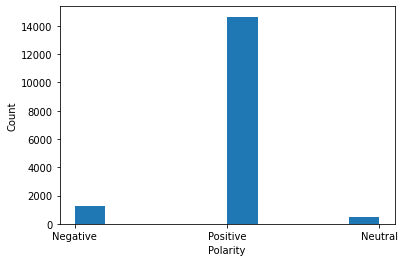

In [13]:
# plot the distribution of polarities
plt.hist(reviews_sample['Polarity'])
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show() 

## Topic Modeling

In [14]:
# tokenize, remove stop words, return tokens

def token_stop(text):
    tokens = word_tokenize(text) # tokenize the text
    newlist = []
    for word in tokens:
        if word not in set(stopwords.words('english')): # remove stop words
          newlist.append(word)
    return newlist

reviews_sample['LDA Reviews'] = reviews_sample['Cleaned Reviews'].apply(token_stop)
reviews_sample.head(2)

,Rating,Content,Cleaned Reviews,Final Reviews,Score,Polarity,LDA Reviews
1,2,The operating system is is an early android. Y...,the operating system is is an early android yo...,oper system earli android cant use download k...,-0.500000,Negative,"[operating, system, early, android, cant, use,..."
2,2,I have been reading on Kindle since the Kindle...,i have been reading on kindle since the kindle...,read kindl sinc kindl releas pretti heavili i...,0.067992,Positive,"[reading, kindle, since, kindle, released, pre..."


In [15]:
dict_ = corpora.Dictionary(reviews_sample['LDA Reviews'])
print(dict_)

Dictionary(28518 unique tokens: ['android', 'barns', 'cant', 'com', 'download']...)


In [16]:
# convert list of documents (corpus) into Document Term Matrix using the dictionary 
doc_term_matrix = [dict_.doc2bow(i) for i in reviews_sample['LDA Reviews']]

In [17]:
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1)],
 [(2, 1),
  (5, 1),
  (8, 6),
  (13, 1),
  (15, 3),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 2),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 5),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 3),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 3),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 2),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 2),


In [18]:
# set training parameters
num_topics = 5
chunksize = 1000
passes = 20
iterations = 400
eval_every = None  # don't evaluate model perplexity, takes too much time

lda = gensim.models.LdaModel

lda_model = lda(doc_term_matrix,
    num_topics=num_topics,
    id2word = dict_,
    iterations=iterations,
    passes=passes,
    eval_every=eval_every,
    random_state=9651
)

In [19]:
lda_model.print_topics(num_words=5)

[(0,
  '0.025*"screen" + 0.012*"kindle" + 0.012*"reading" + 0.012*"battery" + 0.011*"touch"'),
 (1,
  '0.050*"kindle" + 0.046*"fire" + 0.017*"books" + 0.015*"love" + 0.015*"amazon"'),
 (2,
  '0.015*"tablet" + 0.013*"android" + 0.012*"device" + 0.012*"app" + 0.012*"apps"'),
 (3,
  '0.030*"kindle" + 0.019*"fire" + 0.018*"amazon" + 0.011*"one" + 0.010*"get"'),
 (4,
  '0.067*"ipad" + 0.023*"fire" + 0.023*"kindle" + 0.015*"great" + 0.014*"tablet"')]

In [20]:
count = 0
for i in range(5):
    print("doc : ",count,lda_model[doc_term_matrix][i])
    count += 1

doc :  0 [(0, 0.010685884), (1, 0.010917938), (2, 0.5897765), (3, 0.3778801), (4, 0.010739548)]
doc :  1 [(0, 0.4109323), (1, 0.117191955), (2, 0.20412049), (3, 0.12667385), (4, 0.1410814)]
doc :  2 [(0, 0.052070197), (1, 0.8619343), (2, 0.055994958), (4, 0.028720334)]
doc :  3 [(1, 0.6013006), (2, 0.22636475), (4, 0.1663838)]
doc :  4 [(0, 0.35545313), (1, 0.4150662), (2, 0.1651335), (4, 0.05668152)]


In [21]:
reviews_sample["Content"].iloc[1]

'I have been reading on Kindle since the Kindle 2 was released. I am pretty heavily invested in Kindle at this point so the Fire was a logical upgrade...or so I thought. It is a very nice device that is made unuseable, in my opinion, by several flaws. This thing is heavy. Much heavier than it looks. The major problem here is it is difficult to hold. The size and thin bezel just aggravate the situation. The iPad is heavier, but it is bigger so I can lay down, rest my elbows on the bed and hold it comfortably over my chest. I cant get into a comfortable position with the Fire. It is not easy to hold with one hand without accidental touches and it slipping out of my hand. It is also very easy to press the power button while reading. The more I read on the Fire the less I like it. It fails where the early Kindles hit a home run. Those Kindles "disappeared in your hand". With this one, I find myself thinking about the terrible ergonomics and realize I have been spacing out while reading the

In [22]:
# calculate model perplexity
lda_model.log_perplexity(doc_term_matrix)

-7.41318957765125

In [23]:
lda_model_10 = lda(doc_term_matrix,
    num_topics=10,
    id2word = dict_,
    iterations=iterations,
    passes=passes,
    eval_every=eval_every,
    random_state=9651
)

lda_model_10.log_perplexity(doc_term_matrix)

-7.426654494119423

In [24]:
lda_model_20 = lda(doc_term_matrix,
    num_topics=20,
    id2word = dict_,
    iterations=iterations,
    passes=passes,
    eval_every=eval_every,
    random_state=9651
)

lda_model_20.log_perplexity(doc_term_matrix)

-7.461322326107518